# Imports

In [1]:
import os
import pandas as pd

In [10]:
csv_path = '../content/sample_data' # google colab path
#csv_path = '../raw_data' # our pc path
cleandf = pd.read_csv(os.path.join(csv_path, 'clean_data.csv'))

In [11]:
cleandf

,Unnamed: 0,text,target
0,0,smell hillary fear daniel greenfield shillman ...,0
1,1,watch exact moment paul ryan commit political ...,0
2,2,kerry go paris gesture sympathy u secretary st...,1
3,3,bernie supporter twitter erupt anger dnc try w...,0
4,4,battle new york primary matter primary day new...,1
...,...,...,...
6330,6330,state department say can find email clinton sp...,1
6331,6331,p pb stand plutocratic pentagon p pb stand plu...,0
6332,6332,anti trump protester tool oligarchy informatio...,0
6333,6333,ethiopia obama seek progress peace security ea...,1


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.layers import Dense, Conv1D, Embedding, Flatten, Masking, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Variables

In [3]:
es = EarlyStopping(monitor='val_binary_accuracy', patience=10, restore_best_weights=True)

In [4]:
binacc = BinaryAccuracy()
prec = Precision()
rec = Recall()

# Functions

In [5]:
def plot_loss_accuracy(history, title):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))
    
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title(f'{title} Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=2)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    
    
    ax2.plot(history.history['binary_accuracy'])
    ax2.plot(history.history['val_binary_accuracy'])
    ax2.set_title(f'{title} Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=2)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    ax3.plot(history.history['precision'])
    ax3.plot(history.history['val_precision'])
    ax3.set_title(f'{title} Precision')
    ax3.set_ylabel('Precision')
    ax3.set_xlabel('Epoch')
    ax3.set_ylim(ymin=0, ymax=2)
    ax3.legend(['Train', 'Validation'], loc='best')
    ax3.grid(axis="x",linewidth=0.5)
    ax3.grid(axis="y",linewidth=0.5)    
    
    ax4.plot(history.history['recall'])
    ax4.plot(history.history['val_recall'])
    ax4.set_title(f'{title} Recall')
    ax4.set_ylabel('Recall')
    ax4.set_xlabel('Epoch')
    ax4.set_ylim(ymin=0, ymax=2)
    ax4.legend(['Train', 'Validation'], loc='best')
    ax4.grid(axis="x",linewidth=0.5)
    ax4.grid(axis="y",linewidth=0.5)  
    
    plt.show()

In [6]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

In [7]:
# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

In [15]:
def initialize_model (model_name, neurons):
    model = Sequential()
    model.add(Masking(mask_value=0, input_shape=X_train_embed.shape[1:]))
    if model_name == 'lstm':
        model.add(LSTM((neurons*2), return_sequences=False))
        model.add(Dense((neurons), activation='relu'))
    if model_name == 'gru':
        model.add(GRU((neurons*2), return_sequences=False))
        model.add(Dense((neurons), activation='relu'))
    if model_name == 'cnn':
        model.add(Conv1D(neurons, kernel_size=5, activation='tanh'))
        model.add(Flatten())
        model.add(Dense((neurons/2), activation='relu'))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [9]:
def compile_model(model):
    model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001), 
              metrics=[binacc, prec, rec]) 
    return model

# Testing models

## LSTM model

### Preparing data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(cleandf['text'], cleandf['target'], test_size=0.2)
word2vec = Word2Vec(sentences=X_train)
# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)
X_train_embed = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=300)
X_test_embed = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=300)

In [13]:
for X in [X_train_embed, X_test_embed]:
    assert type(X) == np.ndarray
    assert X.shape[-1] == word2vec.vector_size


assert X_train_embed.shape[0] == len(X_train)
assert X_test_embed.shape[0] == len(X_test)

### Testing model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 300, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 112)               95424     
                                                                 
 dense (Dense)               (None, 56)                6328      
                                                                 
 dense_1 (Dense)             (None, 1)                 57        
                                                                 
Total params: 101,809
Trainable params: 101,809
Non-trainable params: 0
_________________________________________________________________
40/40 [==============================] - 5s 124ms/step - loss: 0.5803 - binary_accuracy: 0.6985 - precision: 0.6722 - recall: 0.7337


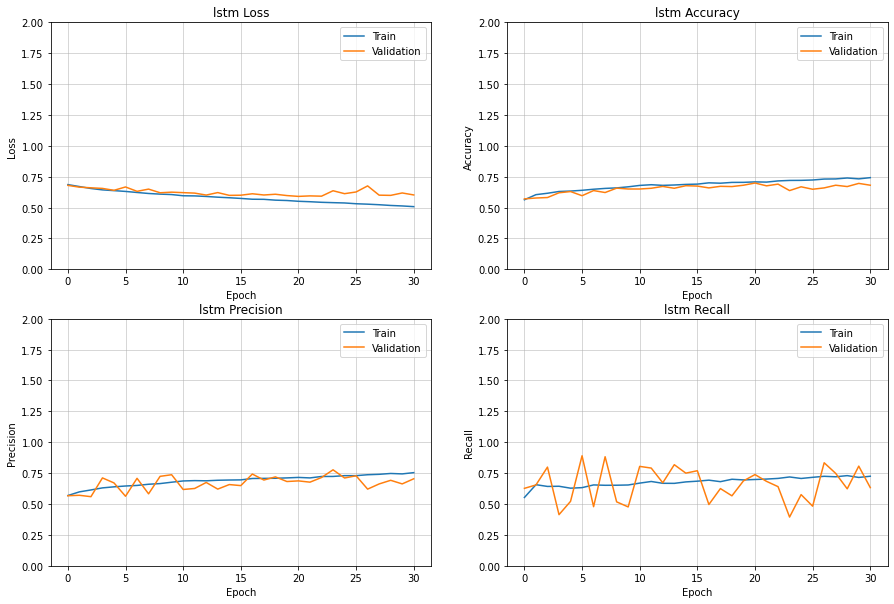

In [16]:
%%time
model = compile_model(initialize_model('lstm', 56))
model.summary()
history = model.fit(X_train_embed, y_train, 
      epochs=50, 
      batch_size=16,
      validation_split=0.2,
      callbacks=[es],
    verbose = 0, 
    use_multiprocessing=True
      )
model.evaluate(X_test_embed, y_test, verbose=1)
plot_loss_accuracy(history, 'lstm')

## GRU model

### Preparing data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(cleandf['text'], cleandf['target'], test_size=0.3)
word2vec = Word2Vec(sentences=X_train)
# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)
X_train_embed = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=300)
X_test_embed = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=300)

### Testing model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 300, 100)          0         
                                                                 
 gru_1 (GRU)                 (None, 112)               71904     
                                                                 
 dense_4 (Dense)             (None, 56)                6328      
                                                                 
 dense_5 (Dense)             (None, 1)                 57        
                                                                 
Total params: 78,289
Trainable params: 78,289
Non-trainable params: 0
_________________________________________________________________
60/60 [==============================] - 5s 77ms/step - loss: 0.5876 - binary_accuracy: 0.6775 - precision: 0.7384 - recall: 0.6040


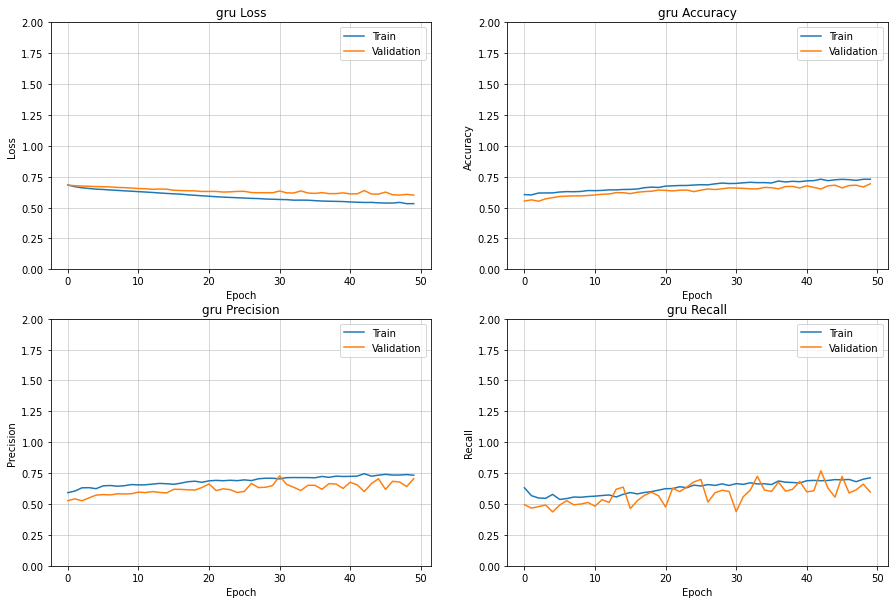

CPU times: user 44min 45s, sys: 1min 15s, total: 46min
Wall time: 24min 52s


In [19]:
%%time
model = compile_model(initialize_model('gru', 56))
model.summary()
history = model.fit(X_train_embed, y_train, 
      epochs=50, 
      batch_size=32,
      validation_split=0.3,
      callbacks=[es],
    verbose = 0, 
    use_multiprocessing=True
      )
model.evaluate(X_test_embed, y_test, verbose=1)
plot_loss_accuracy(history, 'gru')

# Conclusion:
## The way it is now, Word2Vec takes too long and isn't better.
## Maybe if we train in a trained vocabulary using chunks...